In [3]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import keras_models.dataGen as dg 
import keras_models.cnn_models as cm

In [2]:
import keras_models

# Try to mess around with pulling the data
Try using the seizure type, is seizure or not, and the patient identification

In [3]:
train_data = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_seizure_data_4.pkl", "rb"))
valid_data = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_seizure_data_4.pkl", "rb"))
test_data = pkl.load(open("/n/scratch2/ms994/test_multiple_labels_seizure_data_4.pkl", "rb"))

In [4]:
train_edss = train_data
valid_edss = valid_data
test_edss = test_data

In [5]:
train_data[0][1] # is seizure, patient number, seizure type (index of constants.SEIZURE_SUBTYPES)

(False, 40, 0)

In [6]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

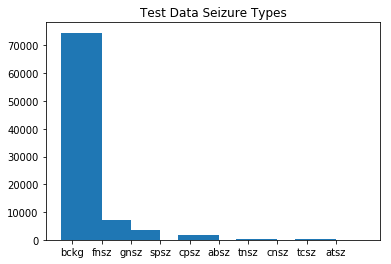

In [8]:
plt.title("Test Data Seizure Types")
num_types, bins, _ = plt.hist([test_data[i][1][2] for i in range(len(test_data))])
plt.bar(height=num_types, x=constants.SEIZURE_SUBTYPES[:-1])

<BarContainer object of 10 artists>

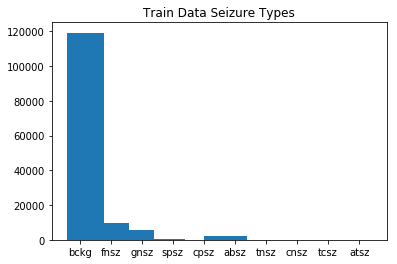

In [9]:
plt.title("Train Data Seizure Types")
num_types, _, _ = plt.hist([train_data[i][1][2] for i in range(len(train_data))])
plt.bar(height=num_types, x=constants.SEIZURE_SUBTYPES[:len(num_types)])

<BarContainer object of 10 artists>

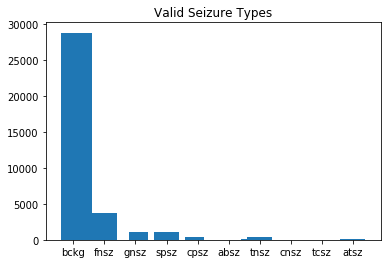

In [10]:
plt.title("Valid Seizure Types")
num_types, _, _ = plt.hist([valid_data[i][1][2] for i in range(len(valid_data))])
plt.bar(height=num_types, x=constants.SEIZURE_SUBTYPES[:len(num_types)])

In [12]:
set([valid_data[i][1][2] for i in range(len(valid_data))])

{0, 1, 2, 4, 6}

In [15]:
set([test_data[i][1][2] for i in range(len(test_data))])

{0, 1, 2, 3, 4, 6, 8, 10}

In [16]:
set([train_data[i][1][2] for i in range(len(train_data))])

{0, 1, 2, 3, 4, 5, 8}

In [19]:
constants.SEIZURE_SUBTYPES

'atsz'

In [8]:
patientInd = [datum[1][1] for datum in train_edss]
seizureLabels = [datum[1][0] for datum in train_edss]
seizureSubtypes = [datum[1][2] for datum in train_edss]
validSeizureSubtypes = [datum[1][2] for datum in valid_edss]
validPatientInd = [datum[1][1] for datum in valid_edss]
validSeizureLabels = [datum[1][0] for datum in valid_edss]
allPatients = list(set([datum[1][1] for datum in train_edss]))

In [26]:
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=3, precache=True, batch_size=64, labels=[seizureLabels, patientInd, seizureLabels], n_classes=(2, len(allPatients), len(constants.SEIZURE_SUBTYPES)),)
valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=3, precache=True, batch_size=64*4, labels=[validSeizureLabels, validPatientInd, validSeizureLabels], xy_tuple_form=True, n_classes=(2, len(allPatients), len(constants.SEIZURE_SUBTYPES)), shuffle=True)
test_edg = dg.DataGenMultipleLabels(test_edss[:], num_labels=3, precache=True, n_classes=(2, len(allPatients), len(constants.SEIZURE_SUBTYPES)), batch_size=64*4, shuffle=False)

In [31]:
valid_labels = []
for batch in valid_edg:
    valid_labels.append(batch[1][0])
valid_labels = np.vstack(valid_labels)
valid_edg.on_epoch_end()
valid_labels.argmax(1).sum()


5140

In [18]:
valid_labels.argmax(1).sum()


5140

5140

In [101]:
test_edg[0]

(array([[[[-3.60817475e-01],
          [-2.04936445e-01],
          [-5.48891304e-01],
          ...,
          [-7.55603095e-01],
          [-5.57363136e-01],
          [-6.86134373e-01]],
 
         [[-2.58557900e+00],
          [-1.42694061e+00],
          [-3.88846985e+00],
          ...,
          [-5.29217571e+00],
          [-3.83386576e+00],
          [-4.86835270e+00]],
 
         [[-8.33339513e+00],
          [-4.41622357e+00],
          [-1.23720132e+01],
          ...,
          [-1.65825318e+01],
          [-1.16706859e+01],
          [-1.55176327e+01]],
 
         ...,
 
         [[ 2.75579375e+01],
          [ 2.09551699e+00],
          [ 4.58283894e+01],
          ...,
          [ 5.12419389e+01],
          [ 1.56110453e+00],
          [ 9.00921967e+00]],
 
         [[ 3.01361566e+01],
          [ 2.61404004e+00],
          [ 5.02087604e+01],
          ...,
          [ 5.48896160e+01],
          [ 5.55902375e+00],
          [ 1.63115628e+01]],
 
         [[ 3.40895440e+

In [97]:
test_edg = dg.DataGenMultipleLabels(test_edss[:], n_classes=2, precache=True, batch_size=64*4, shuffle=False)


TypeError: object of type 'int' has no len()

In [96]:
test_edg[0][1]

(256, 3, 2)

In [81]:
edg.on_epoch_end()

In [89]:
test_edg[0][1]

[array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

In [84]:
valid_edg[0][1]

3

In [80]:
len(valid_edg)

133

In [77]:
num_patients = max([datum[1][1] for datum in train_edss])

In [78]:
num_patients

245

In [68]:
from keras import optimizers
from keras.layers import Dense, TimeDistributed, Input, Reshape, Dropout, LSTM, Flatten
from keras.models import Model, load_model
input_time_size = 4 * constants.COMMON_FREQ
x = Input((input_time_size, 21, 1)) #time, ecg channel, cnn channel
y = x
_, y = cm.conv2d_gridsearch_pre_layers(input_shape=(input_time_size,21,1),
                                            x=y,
                                            conv_spatial_filter=(4,4),
                                            conv_temporal_filter=(4,4),
                                            max_pool_size=(2,1),
                                            max_pool_stride=None,
                                            dropout=0,
                                            num_conv_spatial_layers=3,
                                            num_conv_temporal_layers=6,
                                            num_spatial_filter=8,
                                            num_temporal_filter=4,
                                            use_batch_normalization=True,
                                            time_convolutions_first=True,
                                            max_pool_size_time=(2,1),
                                            
                                      )

y = Flatten()(y)
for i in range(2):
    y = Dense(100, activation='relu')(y)
    y = Dropout(0.25)(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
y_seizure_subtype = Dense(len(constants.SEIZURE_SUBTYPES), activation="softmax", name="seizure_subtype")(y)
y_patient = Dense(len(allPatients), activation="softmax", name="patient")(y)

seizure_model = Model(inputs=x, outputs=[y_seizure])
seizure_patient_model = Model(inputs=[x], outputs=[y_seizure, y_patient,  y_seizure_subtype,])

patient_model = Model(inputs=[x], outputs=[y_patient])
print(seizure_patient_model.summary())
    
lr=0.0001
seizure_weight=1
patient_weight=-1
seizure_model.compile(optimizers.Adam(lr=lr), loss=["categorical_crossentropy"], metrics=["binary_accuracy"])
seizure_patient_model.compile(optimizers.Adam(lr=lr), loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], loss_weights=[seizure_weight,patient_weight, seizure_weight], metrics=["categorical_accuracy"])

patient_model.compile(optimizers.Adam(lr=lr), loss=["categorical_crossentropy"], metrics=["categorical_accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 1000, 21, 1)  4           input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 1000, 21, 32) 544         batch_normalization_90[0][0]     
__________________________________________________________________________________________________
max_pooling2d_90 (MaxPooling2D) (None, 500, 21, 32)  0           conv2d_90[0][0]                  
__________________________________________________________________________________________________
dropout_78

In [66]:
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, f1_score, classification_report

In [69]:
training_seizure_accs = []
valid_seizure_accs = []
train_patient_accs = []
training_seizure_loss = []
valid_seizure_loss = []
subtype_accs = []

oldPatientWeights = patient_model.layers[-1].get_weights()
oldNonPatientWeights = [layer.get_weights() for layer in seizure_model.layers[:-1]]
best_model_loss = 100
patience=20
patience_left=patience
steps_per_epoch=None
model_name = "test_model"
for i in range(100):
        if patience_left == 0:
            continue
    #     edg.start_background()

        valid_labels_full = []
        valid_labels = []
        valid_predictions_full = []
        valid_predictions = []
        

        train_seizure_loss_epoch = []

        seizure_accs = []
        subtype_epochs_accs = []
        patient_accs_epoch = []
        # for j in range(len(edg)):
        if steps_per_epoch is None:
            steps_per_epoch = len(edg)
        for j in range(steps_per_epoch):

            train_batch = edg[j]
            data_x = train_batch[0]
            data_x = data_x.astype(np.float32)
            data_x = np.nan_to_num(data_x)
            loss, seizure_loss, patient_loss, subtype_loss, seizure_acc, patient_acc, subtype_acc = seizure_patient_model.train_on_batch(data_x, train_batch[1])
            seizure_accs.append(seizure_acc)
            #old patient weights are trying to predict for patient, try to do the prediction!
            patient_model.layers[-1].set_weights(oldPatientWeights)
            #keep the other nonpatient weights which try not to predict for patient!
            oldNonPatientWeights = [layer.get_weights() for layer in seizure_model.layers[:-1]]
            patient_loss, patient_acc = patient_model.train_on_batch(train_batch[0], train_batch[1][1])
            patient_accs_epoch.append(patient_acc)

            train_seizure_loss_epoch.append(seizure_loss)
            subtype_epochs_accs.append(subtype_acc)

            #get weights that try to predict for patient
            oldPatientWeights = patient_model.layers[-1].get_weights()

            #set weights that don't ruin seizure prediction
            for layer_num, layer in enumerate(seizure_model.layers[:-1]):
                seizure_model.layers[layer_num].set_weights(oldNonPatientWeights[layer_num])
            if (j % 100) == 0:
                print("epoch: {} batch: {}/{}, seizure acc: {}, patient acc: {}, loss: {}, seizure_subtype accs: {}".format(i, j, len(edg), np.mean(seizure_accs), np.mean(patient_accs_epoch), loss, np.mean(subtype_epochs_accs)))
    #     valid_edg.start_background()

        for j in range(len(valid_edg)):
            valid_batch = valid_edg[i]
            data_x = valid_batch[0]
            data_x = data_x.astype(np.float32)
            data_x = np.nan_to_num(data_x) #ssome weird issue with incorrect data conversion
            val_batch_predictions = seizure_model.predict_on_batch(data_x)
            valid_labels.append(valid_batch[1][0].argmax(1))
            valid_labels_full.append(valid_batch[1][0])
            valid_predictions.append(val_batch_predictions.argmax(1))
            valid_predictions_full.append(val_batch_predictions)


        valid_labels = np.nan_to_num(np.hstack(valid_labels).astype(np.float32))
        valid_predictions = np.nan_to_num(np.hstack(valid_predictions).astype(np.float32))

        print("debug: valid_labels.shape {}, valid_predictions.shape {}".format(valid_labels.shape, valid_predictions.shape))
        print("We predicted {} seizures in the validation split, there were actually {}".format(valid_predictions.sum(), valid_labels.sum()))
        print("We predicted {} seizure/total in the validation split, there were actually {}".format(valid_predictions.sum()/len(valid_predictions), valid_labels.sum()/len(valid_labels)))



        valid_labels_full = np.nan_to_num(np.vstack(valid_labels_full).astype(np.float32))
        valid_predictions_full = np.nan_to_num(np.vstack(valid_predictions_full).astype(np.float32))


        try:
            auc = roc_auc_score(valid_predictions, valid_labels)
        except Exception:
            auc = "undefined"
        valid_acc =  accuracy_score(valid_predictions, valid_labels)
        valid_seizure_accs.append(valid_acc)
        train_patient_accs.append(np.mean(patient_accs_epoch))
        valid_loss = log_loss(valid_labels_full, valid_predictions_full)
        training_seizure_loss.append(np.mean(train_seizure_loss_epoch))
        valid_seizure_loss.append(valid_loss)
        subtype_accs.append(np.mean(subtype_epochs_accs))
        print("end epoch: {}, f1: {}, auc: {}, acc: {}, loss: {}\n".format(i, f1_score(valid_predictions, valid_labels), auc, valid_acc, valid_loss))
        print(classification_report(valid_labels, valid_predictions))
        if (valid_loss < best_model_loss):
            patience_left = patience
            best_model_loss = valid_loss
            try:
                seizure_model.save(model_name)
                print("improved val score to {}".format(best_model_loss))
            except Exception as e:
                print("{}\n".format(e))
                print("failed saving\n")
        else:
            patience_left -= 1
            if patience_left == 0:
                print("Early Stopping!")




        training_seizure_accs.append(np.mean(seizure_accs))

        edg.on_epoch_end()
        valid_edg.on_epoch_end()


epoch: 0 batch: 0/585, seizure acc: 0.546875, patient acc: 0.0, loss: -2.052402973175049, seizure_subtype accs: 0.109375
epoch: 0 batch: 100/585, seizure acc: 0.6115408539772034, patient acc: 0.004486386198550463, loss: -4.131728172302246, seizure_subtype accs: 0.41460394859313965
epoch: 0 batch: 200/585, seizure acc: 0.6230565905570984, patient acc: 0.0070740049704909325, loss: -7.521538257598877, seizure_subtype accs: 0.4458177983760834
epoch: 0 batch: 300/585, seizure acc: 0.6279069781303406, patient acc: 0.007267442066222429, loss: -7.448182106018066, seizure_subtype accs: 0.4486088156700134
epoch: 0 batch: 400/585, seizure acc: 0.6350919604301453, patient acc: 0.00798784289509058, loss: -7.98509407043457, seizure_subtype accs: 0.46317797899246216
epoch: 0 batch: 500/585, seizure acc: 0.646332323551178, patient acc: 0.009356287308037281, loss: -6.446347236633301, seizure_subtype accs: 0.47813746333122253
debug: valid_labels.shape (10304,), valid_predictions.shape (10304,)
We predic

epoch: 5 batch: 200/585, seizure acc: 0.8300684094429016, patient acc: 0.054415423423051834, loss: -12.592249870300293, seizure_subtype accs: 0.7681125402450562
epoch: 5 batch: 300/585, seizure acc: 0.8289555907249451, patient acc: 0.05601121112704277, loss: -11.28227710723877, seizure_subtype accs: 0.7683762311935425
epoch: 5 batch: 400/585, seizure acc: 0.8310084342956543, patient acc: 0.059265896677970886, loss: -10.393728256225586, seizure_subtype accs: 0.7681577205657959
epoch: 5 batch: 500/585, seizure acc: 0.8319610953330994, patient acc: 0.06200099736452103, loss: -9.42205810546875, seizure_subtype accs: 0.7705214619636536
debug: valid_labels.shape (10304,), valid_predictions.shape (10304,)
We predicted 1932.0 seizures in the validation split, there were actually 4991.0
We predicted 0.1875 seizure/total in the validation split, there were actually 0.484375
end epoch: 5, f1: 0.5581395348837209, auc: 0.8173076923076923, acc: 0.703125, loss: 0.5985865495240432

              preci

KeyboardInterrupt: 

In [38]:
roc_auc_score(valid_predictions, valid_labels)

0.75

# try debugging EdfDatasetSegmentedSampler and add montage channel info

In [4]:
eds = er.EdfDatasetSegments(pre_cooldown=4, post_cooldown=4, sample_time=4, num_seconds=4, n_process=10)

Starting 10 processes
retrieving: 0
Starting 10 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [5]:
train_pairs = eds.get_train_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [6]:
train_pairs

[('/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  00:00:00    bckg
  00:00:04    bckg
  00:00:08    bckg
  00:00:12    bckg
  00:00:16    bckg
  00:00:20    bckg
  00:00:24    bckg
  00:00:28    bckg
  00:00:32    bckg
  00:00:36    bckg
  00:00:40    bckg
  00:00:44    bckg
  00:00:48    bckg
  00:00:52    bckg
  00:00:56    bckg
  00:01:00    bckg
  00:01:04    bckg
  00:01:08    bckg
  00:01:12    bckg
  00:01:16    bckg
  00:01:20    bckg
  00:01:24    bckg
  00:01:28    bckg
  00:01:32    bckg
  00:01:36    bckg
  00:01:40    bckg
  00:01:44    bckg
  00:01:48    bckg
  00:01:52    bckg
  00:01:56    bckg
              ... 
  00:19:40    bckg
  00:19:44    bckg
  00:19:48    bckg
  00:19:52    bckg
  00:19:56    bckg
  00:20:00    bckg
  00:20:04    bckg
  00:20:08    bckg
  00:20:12    bckg
  00:20:16    bckg
  00:20:20    bckg
  00:20:24    bckg
  00:20:28    bckg
  00:20:32    bckg
  00:20:36    bckg
  00:20:40    bckg
  00:20:44 

In [45]:
reload(er)
edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_pairs, mode=er.EdfDatasetSegmentedSampler.DETECT_MODE, num_samples=100, n_process=10, gap=4*pd.Timedelta(seconds=1), include_seizure_type=True)

In [46]:
returned = edss[0]

In [26]:
indexData = returned[1]
per_channel_ann = returned[2]

In [24]:
start = indexData.sample_num * indexData.sample_width / pd.Timedelta(seconds=1)
end = (indexData.sample_num+1) * indexData.sample_width / pd.Timedelta(seconds=1)

In [25]:
start, end

(996.0, 1000.0)

In [35]:
indexData

{'label': (False, 'bckg'),
 'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
 'sample_num': 249.0,
 'sample_width': Timedelta('0 days 00:00:04')}

In [47]:
returned

(array([[ 3.18393549e-01,  8.04241918e-02,  1.39781882e-02, ...,
          1.19055570e-01,  8.39917330e-01, -1.17368535e-01],
        [ 2.27378474e+00,  5.14503803e-01,  3.69177370e-01, ...,
          9.98731855e-01,  5.92471342e+00, -5.68234978e-01],
        [ 7.16517149e+00,  1.45238241e+00,  2.07135971e+00, ...,
          3.64023327e+00,  1.85372054e+01, -8.74565202e-01],
        ...,
        [ 1.33649381e+01,  3.67584830e+00,  1.30541153e-01, ...,
          7.41222403e-01, -4.60066352e+00, -2.60575567e+01],
        [ 3.45862106e+01,  1.16821389e+01,  9.37792215e+00, ...,
          7.96159939e+00,  9.98996219e+00, -2.18858864e+01],
        [ 4.58602171e+01,  1.74468352e+01,  1.37553438e+01, ...,
          1.05904740e+01,  2.20455961e+01, -1.67763006e+01]]),
 {'label': (False, 'bckg'),
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 85.0,
  'sample_width': Timedelta('0 days 00:00:04')},
 C3-CZ     0.0


In [51]:
(*(5,6), 7)

(5, 6, 7)